# Emotional Dialogues Project

Participants: 
- Rachel Kim
- Igor Katselenbogen
- Filippo Manzardo


## What is given?

Dataset: The dataset consist of short conversation passages (of 3 to 5 utterances each), each labelled with an emotion.
- Task: The original task on this dataset was to generate responses in the dialogue that respect the target emotion, but the dataset could also be used for sentiment analysis: i.e. to identify the emotion associated with each utterance in the dialogue.
- Hints and suggestions: You could apply various classifiers for the sentiment analysis task including Transformer based models like BERT. Does knowing the previous (or subsequent) utterance improve the classifier performance? Note also that we will demonstrate text generation techniques in the latter practical sessions of the course.


## The task

The aim of the assignment is to apply the techniques you have learnt in class to analyse one of the text datasets described below. The exact tasks performed may depend on the dataset chosen, but we would expect to see some of the following:
### 1. Preliminary analysis:
Briefly describe the dataset:
- what type of documents does it contain?
- how many documents are there?
- calculate and visualise some simple statistics for the collection, e.g. the average document
length, the average vocabulary size, etc.
Play around with documents, using some of the code from the early parts of the course. You could, for example:
- cluster the documents and visualise the clusters to see what types of groups are present (or whether the known classes can be found);
- index the documents so that you can perform keyword search over them;
- train a Word2Vec embedding on the data and investigate the properties of the resulting
embedding.
   
### 2. Training models:
Each of the datasets comes with a particular task that you need to perform, so:
- train a model to perform that task (by fine-tuning models on the training data);
- test pre-trained models on the task (if they already exist); and
- evaluate different models and compare their performance.
HINT: as a minimum here we would expect to see a linear classifier trained on the data (if an appropriate for the task) and compare it with deep learning model, such as BERT.

### 3. Possible extensions:
Depending on the dataset chosen there will be many additional investigations you can perform. For instance, oftentimes we can improve performance of a model on a particular task by simply including additional data that is related to the task in its training set. So see if you can find other data that helps with the task that you chose. Moreover, there are many NLP challenges out there, so if you can’t find more data for the task you’re working on, look for another interesting challenge to work on.

## Prepare environment

Please use Python `< 3.11`, this notebook was run using Python `3.10.3`

In [6]:
%pip install tensorflow-macos==2.9 tensorflow-metal==0.5.0


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install pandas seaborn matplotlib transformers scikit-learn ktrain httpx

# Install tensorflow-metal if environment uses Apple Silicon
import os
if os.uname().machine == 'arm64':
    %pip install tensorflow-macos==2.9 tensorflow-metal==0.5.0
else:
    %pip install tensorflow


  Using cached pandas-2.0.1-cp310-cp310-macosx_11_0_arm64.whl (10.8 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached matplotlib-3.7.1-cp310-cp310-macosx_11_0_arm64.whl (7.3 MB)
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
  Using cached scikit_learn-1.2.2-cp310-cp310-macosx_12_0_arm64.whl (8.5 MB)
  Using cached ktrain-0.37.0-py3-none-any.whl
  Using cached httpx-0.24.1-py3-none-any.whl (75 kB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached numpy-1.24.3-cp310-cp310-macosx_11_0_arm64.whl (13.9 MB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached Pillow-9.5.0-cp310-cp310-macosx_11_0_arm64.whl (3.1 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached contourpy-1.0.7-cp310-cp310-macosx_11_0_arm64.whl (229 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp310-cp310-macosx_11_0_arm64.whl (63 kB)
  Using cached fonttools-4.39.4-py3-none-a

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
import re
import string
import ktrain
import numpy as np
import sklearn
import tensorflow as tf
import transformers
import httpx


/Users/amiable-sputnik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  Data loading
First thing we need to do is load a set of documents that we can cluster.

### TODO: Write about the dataset

#### Download from Source

In [150]:
dataset_url = 'https://drive.google.com/u/0/uc?id=1AqxpBMFVDX-hUGA-treA8ffnSdyu0ggJ&export=download&confirm=t&uuid=a9c55950-657f-4984-adfd-368ac09e153e&at=AKKF8vyKSfG7CIDYm5OxPgCkteAp:1682881890156'
url = requests.get(dataset_url)
csv_raw = StringIO(url.text)
df = pd.read_csv(dataset_url)

print(f"Downloaded dataset with {df.shape[0]} rows and {df.shape[1]} columns, from {dataset_url}")

KeyboardInterrupt: 

#### Load from storage

In [156]:
dataset_path = "./dataset.csv"
df = pd.read_csv(dataset_path)
print(f"Downloaded dataset with {df.shape[0]} rows and {df.shape[1]} columns, from {dataset_path}")

Downloaded dataset with 2829426 rows and 5 columns, from ./dataset.csv


## Data analysis

Let's go over some basic information about the data and analize it together. 

In [157]:
df.head()

,dialogue_id,turn,uttr,eb+_emot,label_confidence
0,97,1,You moron ! What fool washes diapers by the we...,angry,0.437522
1,97,2,You useless fool !,furious,0.731564
2,99,1,How dare you sleep !,furious,0.605636
3,99,2,Up ! Go and clean the house .,prepared,0.650449
4,100,1,Clean the kitchen .,prepared,0.742187


The dataset is composed by 5 columns, where the text part is under the `uttr` and its related emotion in `eb+_emot`. We have an associated confidence `label_confidence` with which the emotion is assigned to the utterance.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829426 entries, 0 to 2829425
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dialogue_id       int64  
 1   turn              int64  
 2   uttr              object 
 3   eb+_emot          object 
 4   label_confidence  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 107.9+ MB


First thing we could say is that we have **2 829 426** entries in our dataset and **5** columns. 

### TODO: Write it better

Let's go over the columns and see a bit closer what each of them mean:

*   dialogue_id — an identificator of the dialogue. It would be helpful for us, 
*   turn —
*   uttr — 
*   label_confidence —
*   eb+_emot —

The target column for our purposes is eb+_emot. Let's see a bit more about the values in there:

In [154]:
df.describe()

,dialogue_id,turn,label_confidence
count,6.398040e+05,639804.000000,639804.000000
mean,4.389452e+06,2.192140,0.963563
std,2.552430e+06,1.291644,0.021699
min,5.300000e+01,1.000000,0.920000
25%,2.161876e+06,1.000000,0.945978
50%,4.392924e+06,2.000000,0.966424
75%,6.574250e+06,3.000000,0.982289
max,8.820637e+06,13.000000,0.999581


Let's analyze the vocabulary, finding information about words and documents

In [158]:
# Find unique words in the `uttr` column, it contains a string so we need to split it first
count = df['uttr'].str.split(expand=True).stack().value_counts()

print(f"Unique words in `uttr` column: {len(count)}")
print(f"Total words count: {count.sum()}")

Unique words in `uttr` column: 328076
Total words count: 39469825


In [89]:
# Find most common words and print 10 of them, we can see that most of them are stopwords
print(count[:10])

.      3353836
,      1691931
?      1325835
I      1192718
you    1170603
the     803960
to      729538
's      611811
a       537957
!       505285
Name: count, dtype: int64


In [90]:
# What about the most uncommon words?
print(count[-10:])

Tamizhselvan       1
XT-85              1
Flubba             1
Katahdin           1
Hodda              1
Gosev              1
Davenport-Scott    1
Edaxiang           1
Sower              1
unpriestly         1
Name: count, dtype: int64


In [140]:
# Which are the longest words in the dataset?
top_lenghts = count.index.str.len().sort_values(ascending=False)[:10]
print(top_lenghts.values)

# Print the longest word, the word not the lenght of it
print(list(filter(lambda x: len(x) in top_lenghts.values, count.index)))

[30 30 29 29 29 29 28 27 26 26]
['Whoistheculpritthatspokeill', 'Three-hundred-thousand-dollar', 'wathanceyherapmibamnashulakha', 'StargateDanielFriendly.Net', 'I-never-got-any-in-high-school', 'Aaaaaaaaaaaaaaaaaaaaaaaaah', 'wooowooo-wooo-wooo-wooo-wooo', 'Whoa-whoa-whoa-whoa-whoa-whoa', 'get-the-fuck-out-of-my-way', 'LikethedeathyougaveNeelima', 'Hippopotomonstrosesquipedalio', 'You-want-me-give-something-you', 'Perhapsltalianslookalittle']


In [141]:
names = ['igor', 'rachel', 'filippo']

for name in names:
  if name in count:
    print("Yes! Name " + name.capitalize() + " is present in the dataset!")
  else: 
    print("Ooops! " + name + " is now famous enough!")

Ooops! igor is now famous enough!
Yes! Name Rachel is present in the dataset!
Ooops! filippo is now famous enough!


Let's now take a look at the distribution of labels in our dataset

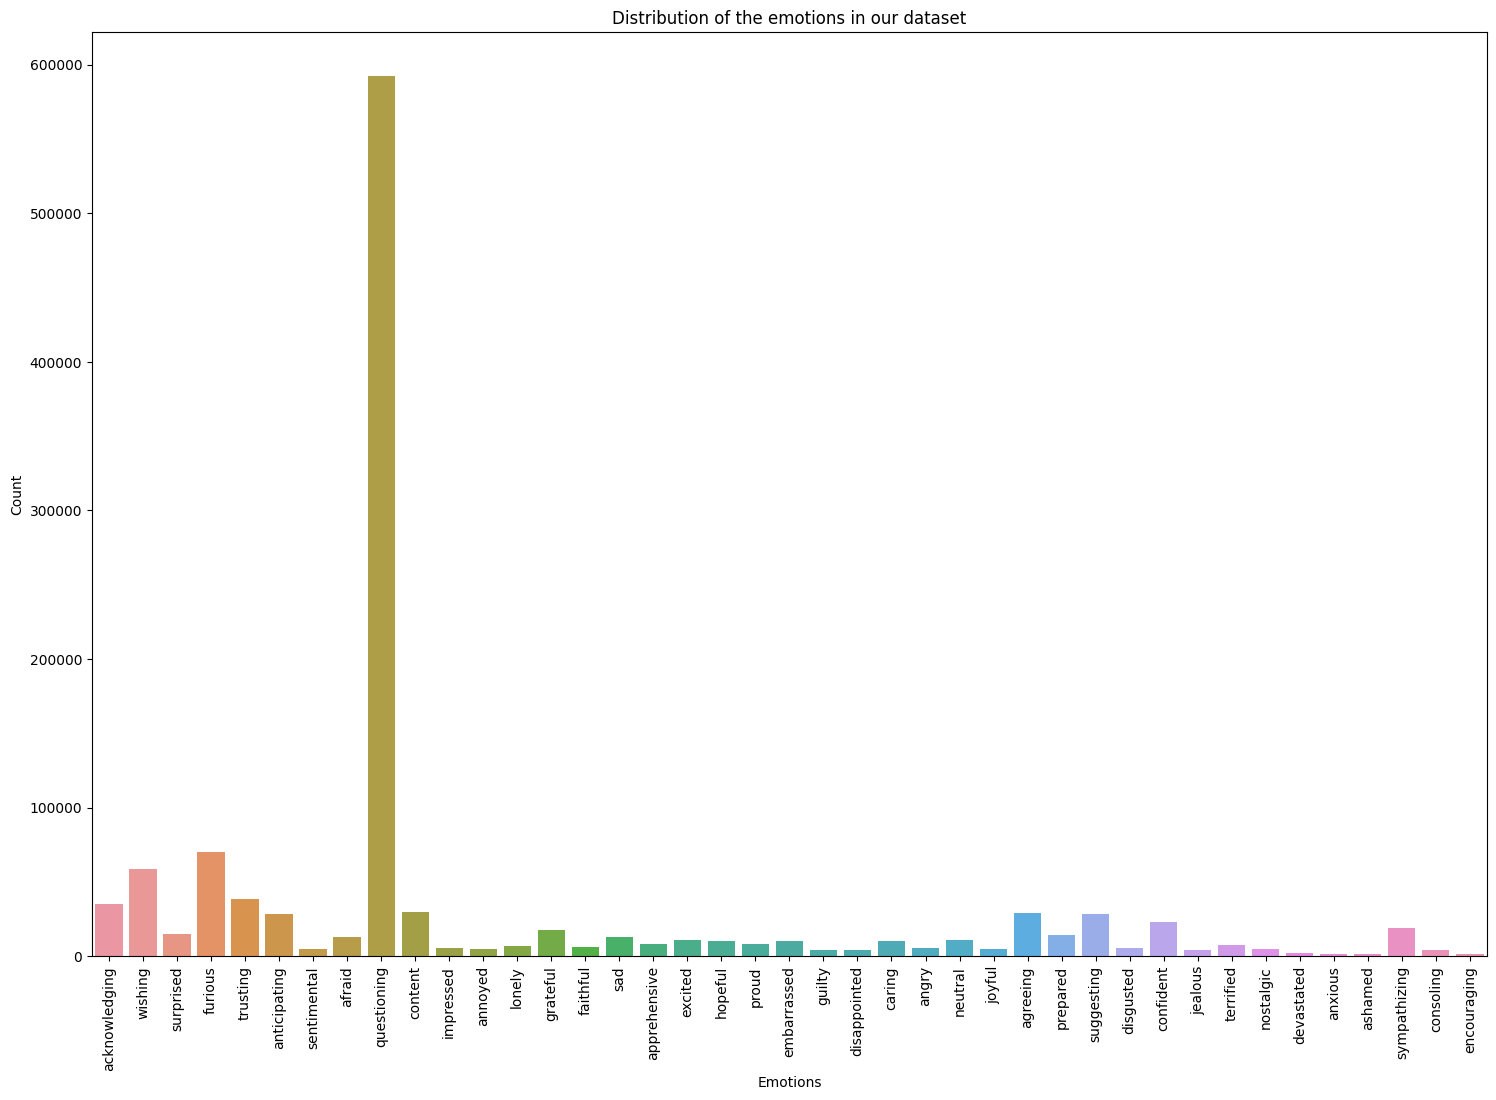

In [129]:
plt.figure(figsize=(18, 12))
sns.countplot(data=df, x='eb+_emot')

plt.title('Distribution of the emotions in our dataset')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

We can see that the emotions aren't distributed proportionally. There is clear disbalance: most of the entries have questioning emotions. That is normal in real datasets, but it just simply means that we need to account it in our work.

Let's investigate the vocabulary even more.

In [159]:
all_words_all_replics_raw = [word.lower() for uttr in df['uttr'].str.split() for word in uttr]
len(all_words_all_replics_raw)

39469825

Amazing! We can see that total we have **39 469 825** words in our vocabulary.
But how many of them are unique?

In [160]:
vocab_set = set(all_words_all_replics_raw)
print(len(vocab_set))

265910


Interesting! As we expected, we have way less unique values than amount of words in our database. But still impressive, we have 265 910 unique words. Of course, we still didn't clean our document from the punctuation signs and etc.

Let's do it now!

In [163]:
import string
import re
regex = '[' + string.punctuation + ']'

all_words_no_punctuation = [re.sub(regex, '', word.lower()) for message in df['uttr'].str.split() for word in message]
vocab_no_punctuation_set = set(all_words_no_punctuation)
print(len(vocab_no_punctuation_set))
print(all_words_no_punctuation[0])

250575
you


Still impressive! 250 575 words. Did you know that in modern use there are about 170 000 words and each person use only about 20-30 thouthands words?
Let's do something interesting and see if the names of our team members are in the data set?

In [164]:
names = ['igor', 'rachel', 'filippo']

for name in names:
  if name in vocab_no_punctuation_set:
    print("Yes! Name " + name.capitalize() + " is present in the dataset!")
  else: 
    print("Ooops! " + name + " is now famous enough!")

Yes! Name Igor is present in the dataset!
Yes! Name Rachel is present in the dataset!
Yes! Name Filippo is present in the dataset!


### TODO: Maybe we could write the surroundings of the names?

Let's try to see the word count per category:

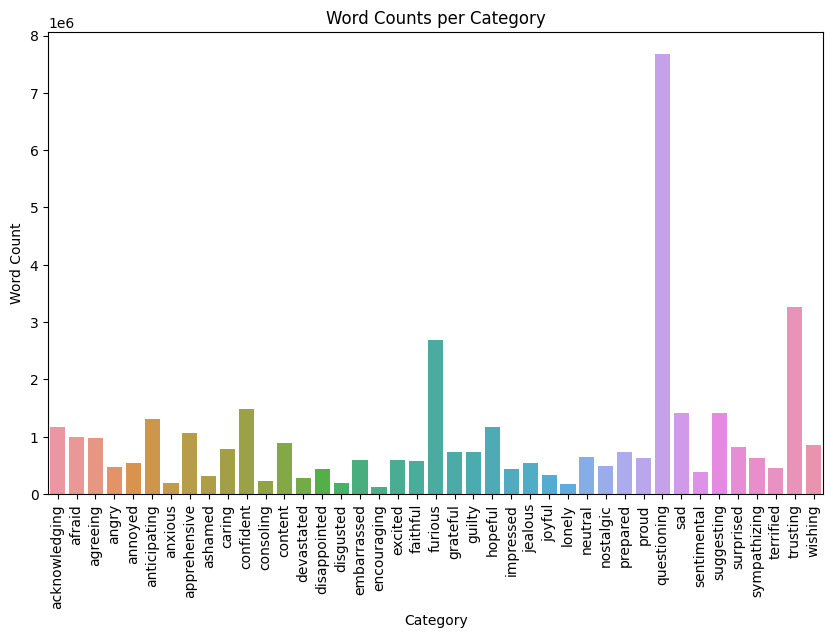

In [166]:
df['word_count'] = df['uttr'].apply(lambda x: len(str(x).split()))
word_counts_per_category = df.groupby('eb+_emot')['word_count'].sum().reset_index()

# Plotting the word counts
plt.figure(figsize=(10, 6))
sns.barplot(data=word_counts_per_category, x='eb+_emot', y='word_count')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.title('Word Counts per Category')
plt.xticks(rotation=90)
plt.show()

Interesting! We see that anxious and annoyed people talk less than furious or trusting, for example. 
It is hard to find the application of this right now in our specific task, but this findings makes the job of NLP researcher special. 


Also, we can try to learn how big our vocabulary would be if we also cut the stop words:

In [167]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vectorizer.fit(df['uttr'])
print(len(vectorizer.get_feature_names_out()))

221237


With vectorizers we also eliminate stop words, and we see that the current vocabulary is **221 237** words. It still seems like a regular size for the NLP applications. 

Now, let's just see what some of the categories are containing.
For example, we would take the following:

*   Angry
*   Furious
*   Prepared
*   Caring
*   Wishing
*   Lonely
*   Proud
*   Jealous

In [168]:
for category in ['angry', 'furious','prepared', 'caring', 'wishing', 'lonely', 'proud', 'jealous']:
    category_texts = df[df['eb+_emot'] == category]['uttr'].head(2).tolist()
    print(f'Examples of texts for category "{category}":')
    for text in category_texts:
        print(text)
    print()

Examples of texts for category "angry":
You moron ! What fool washes diapers by the well !
Emigration must not stop ! It has to continue !

Examples of texts for category "furious":
You useless fool !
How dare you sleep !

Examples of texts for category "prepared":
Up ! Go and clean the house .
Clean the kitchen .

Examples of texts for category "caring":
Granny ...
I love you , Dad .

Examples of texts for category "wishing":
Hi there , Welcome to the Stockroom .
Owner of Optic Nerve Makeup Effect Studio Glenn Hetrick ... Good evening , gentlemen . Hey , Glenn . Three-time Oscar-winning makeup artist Ve Neill ... Hi , guys . Hey , Ve . Creature and concept designer Neville Page .

Examples of texts for category "lonely":
Completely empty .
He doesn 't have any companions .

Examples of texts for category "proud":
Not setting up one of your friends . I couldn 't do what you did . So looks like you 're the one .. .. teaching me . What real character and integrity is all about . I love y

Interesting! However, we can see that this task of sentiment analysis is not easy even for us! 

Since we have so many categories, some of them are too close to each other. For example, Angry and Furious. Also, some of the samples, would be hard to refer to any category and therefore their assignment is very ambigious. For example, the sentence about the Italian men.

Let's also see what is the most common sentiment for the first and the second turn. Let's just be a cool kids and keep being curious! :)

In [169]:
turn_1_df = df[df['turn'] == 1]
turn_2_df = df[df['turn'] == 2]
most_common_category_1 = turn_1_df['eb+_emot'].value_counts().idxmax()
most_common_category_2 = turn_2_df['eb+_emot'].value_counts().idxmax()
print("The most common category for turn 1 is:", most_common_category_1)
print("The most common category for turn 2 is:", most_common_category_2)

The most common category for turn 1 is: questioning
The most common category for turn 2 is: questioning


Again, not much new for us. The result makes sense since the questioning category is way larger than anything else, but we tried! 
Let's go to the next stage! 

### TODO: What else could we write? 

1. We can do an analysis how many words for each category per one response in average?
2. They usually have turns in the database. We can do the following: analyse which is the most common first category? (maybe question) and what is the most common second category?
3. then we can do some more fun analysis? for example analyse what is the most common answer for the angry/furious category if that is the first one.

## Training

The dataset is huge and unbalanced. We most probably don't need all samples, so we equalize the dataset by taking samples up to the least number of apperances of labels.

In [130]:
# Take an equel nuber of samples based on the least represented emotion
min_count = df['eb+_emot'].value_counts().min()
df_reduced = df.groupby('eb+_emot').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Split train and test data
train, test = train_test_split(df_reduced, test_size=0.2, random_state=42)
label_to_id = {
    label: index
    for index, label in enumerate(train['eb+_emot'].unique())
}

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

Train dataset shape: (38408, 5)
Test dataset shape: (9603, 5)


Let's now apply some common clean-up lambdas to the dataset utterances

In [131]:
#Use regex to clean the data
def remove_url(text: str) -> str:
    """Remove URLs from a string"""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text: str) -> str:
    """Remove punctuation from a string"""
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text: str) -> str:
    """Remove html tags from a string"""
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text: str) -> str:
    """Remove emojis from a string"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text: str) -> str:
    """Decontraction helper"""
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text: str) -> str:
    """Seperate alphanumeric characters"""
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text: str) -> str:
    """Remove characters repeated more than twice in a row"""
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep: str, text: str) -> str:
    """Remove characters repeated more than twice in a row"""
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def label_to_idx(label: str) -> str:
    """Convert label to index, making labels into categorical numbers"""
    return label_to_id[label]



train['uttr'] = train['uttr'].apply(lambda x : remove_url(x))
train['uttr'] = train['uttr'].apply(lambda x : remove_punct(x))
train['uttr'] = train['uttr'].apply(lambda x : remove_emoji(x))
train['uttr'] = train['uttr'].apply(lambda x : decontraction(x))
train['uttr'] = train['uttr'].apply(lambda x : seperate_alphanumeric(x))
train['uttr'] = train['uttr'].apply(lambda x : unique_char(cont_rep_char,x))
train['eb+_emot'] = train['eb+_emot'].apply(lambda x : label_to_idx(x))

test['uttr'] = test['uttr'].apply(lambda x : remove_url(x))
test['uttr'] = test['uttr'].apply(lambda x : remove_punct(x))
test['uttr'] = test['uttr'].apply(lambda x : remove_emoji(x))
test['uttr'] = test['uttr'].apply(lambda x : decontraction(x))
test['uttr'] = test['uttr'].apply(lambda x : seperate_alphanumeric(x))
test['uttr'] = test['uttr'].apply(lambda x : unique_char(cont_rep_char,x))
test['eb+_emot'] = test['eb+_emot'].apply(lambda x : label_to_idx(x))

## Baseline Classifier

In [76]:
# Let's train a linear SVM classifier as a baseline model
# We will use TF-IDF to vectorize the text
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train['uttr'])
test_vectors = vectorizer.transform(test['uttr'])

classifier = sklearn.svm.LinearSVC()
classifier.fit(train_vectors, train['eb+_emot'])

# Predict on the test dataset
predictions = classifier.predict(test_vectors)

# Print the classification report
print(sklearn.metrics.classification_report(test['eb+_emot'], predictions))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59      1694
           1       0.60      0.60      0.60      1722
           2       0.65      0.70      0.67      1689
           3       0.59      0.65      0.62      1742
           4       0.73      0.83      0.78      1689
           5       0.54      0.50      0.52      1730
           6       0.54      0.54      0.54      1778
           7       0.49      0.50      0.49      1754
           8       0.66      0.66      0.66      1695
           9       0.42      0.36      0.39      1702
          10       0.45      0.38      0.41      1745
          11       0.48      0.50      0.49      1701
          12       0.54      0.46      0.49      1727
          13       0.35      0.35      0.35      1703
          14       0.51      0.51      0.51      1727
          15       0.53      0.59      0.56      1713
          16       0.55      0.52      0.54      1758
          17       0.68    

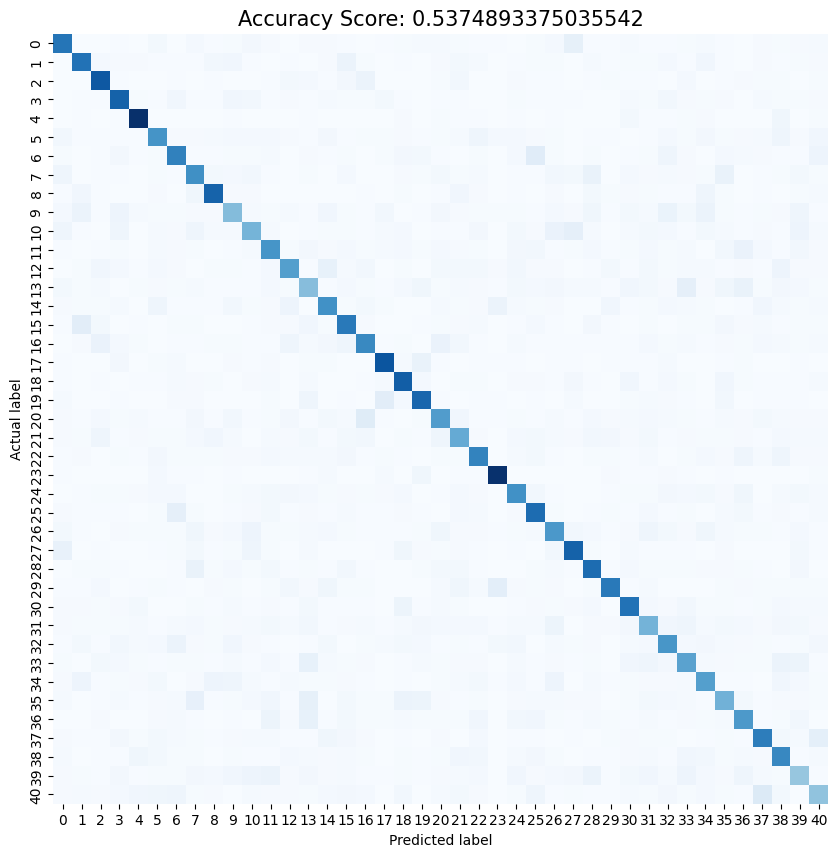

In [77]:
# Plot Confusion Matrix
cm = sklearn.metrics.confusion_matrix(test['eb+_emot'], predictions)
plt.figure(figsize=(10,10))
# No labels in the heatmap cause it messes up the plot
sns.heatmap(cm, cmap='Blues', cbar=False)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(sklearn.metrics.accuracy_score(test['eb+_emot'], predictions))
plt.title(all_sample_title, size = 15)
plt.show()

In [79]:
import sklearn.naive_bayes
# Let's try now with a naive bayes classifier
classifier = sklearn.naive_bayes.MultinomialNB()
classifier.fit(train_vectors, train['eb+_emot'])

# Predict on the test dataset
predictions = classifier.predict(test_vectors)

# Print the classification report
print(sklearn.metrics.classification_report(test['eb+_emot'], predictions))

              precision    recall  f1-score   support

           0       0.52      0.62      0.56      1694
           1       0.58      0.55      0.56      1722
           2       0.72      0.58      0.64      1689
           3       0.47      0.71      0.57      1742
           4       0.77      0.70      0.74      1689
           5       0.36      0.60      0.45      1730
           6       0.57      0.45      0.51      1778
           7       0.48      0.43      0.45      1754
           8       0.45      0.66      0.54      1695
           9       0.27      0.57      0.37      1702
          10       0.33      0.52      0.41      1745
          11       0.54      0.43      0.48      1701
          12       0.58      0.39      0.47      1727
          13       0.53      0.18      0.26      1703
          14       0.37      0.65      0.47      1727
          15       0.66      0.48      0.55      1713
          16       0.66      0.39      0.49      1758
          17       0.55    

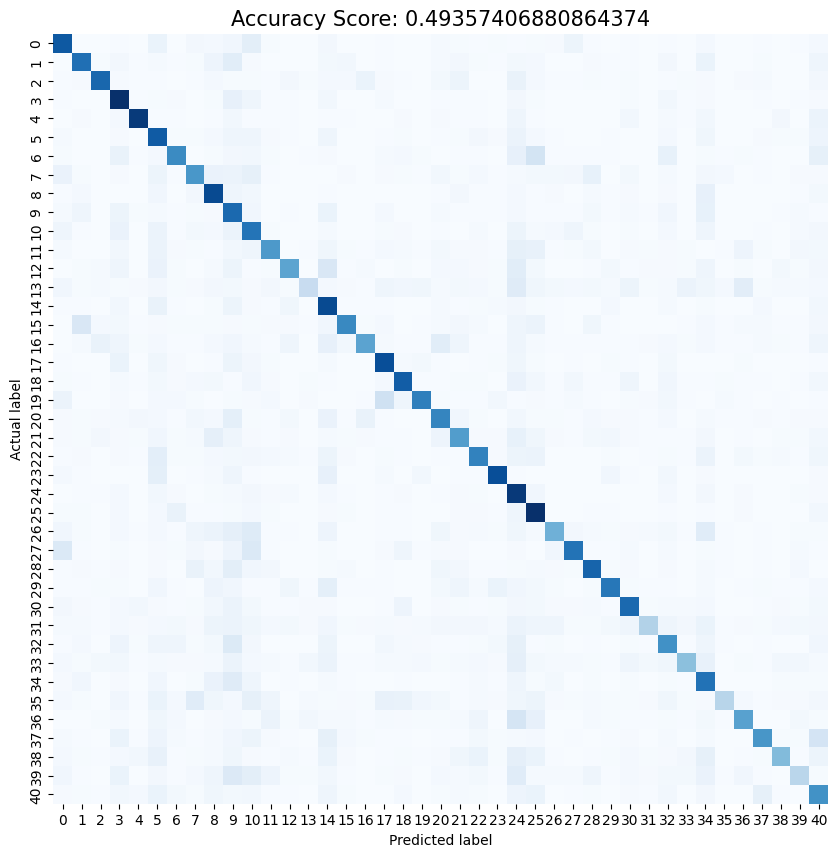

In [80]:
# Plot Confusion Matrix
cm = sklearn.metrics.confusion_matrix(test['eb+_emot'], predictions)
plt.figure(figsize=(10,10))
# No labels in the heatmap cause it messes up the plot
sns.heatmap(cm,  cmap='Blues', cbar=False)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(sklearn.metrics.accuracy_score(test['eb+_emot'], predictions))
plt.title(all_sample_title, size = 15)
plt.show()

Let's try now using a BERT model

In [132]:
# Smallest bert model
MODEL_NAME = 'distilroberta-base'
transformer = ktrain.text.Transformer(MODEL_NAME, maxlen=500, classes=df["eb+_emot"].unique().tolist())

# Shrink train and test data to 200 samples per class, too much for my laptop. Keep classes balanced
train_reduced = df.groupby('eb+_emot').apply(lambda x: x.sample(n=200, random_state=1)).reset_index(drop=True)
test_reduced = df.groupby('eb+_emot').apply(lambda x: x.sample(n=200, random_state=1)).reset_index(drop=True)

print("New train shape: ", train_reduced.shape)
print("New test shape: ", test_reduced.shape)

processed_train = transformer.preprocess_train(train_reduced['uttr'].to_list(), train_reduced['eb+_emot'].to_list())
processed_test = transformer.preprocess_test(test_reduced['uttr'].to_list(), test_reduced['eb+_emot'].to_list())

/Users/amiable-sputnik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/ktrain/text/preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


New train shape:  (8200, 5)
New test shape:  (8200, 5)
preprocessing train...
language: en
train sequence lengths:
	mean : 14
	95percentile : 40
	99percentile : 61


/Users/amiable-sputnik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 14
	95percentile : 40
	99percentile : 61


Let's try without fine tuning

In [117]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=32)
learner.validate(class_names=transformer.get_classes())

KeyboardInterrupt: 

In [85]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=32)
learner.fit_onecycle(5e-5, 1)
learner.validate(class_names=transformer.get_classes())



begin training using onecycle policy with max lr of 5e-05...
 37/257 [===>..........................] - ETA: 19:27 - loss: 3.7161 - accuracy: 0.0270

KeyboardInterrupt: 

We had to stop the training as we didn't have enough time to do it properly. 
Eventhough, it was interesting to see and understand how heavy this is!

### Chat GPT API

As it seems close to impossible to train the BERT model in our case, we tried a shortcut approach — 
using the OpenAI free API to prepare the prompt with the request to predict the sentiment for us. 

TDLR;

This approach didn't show us much result. Partially because there are many labels with small confidence in the dataset. 
Partially because it might still be hard to unserstand such broad range of sentiments, even for chat GPT. 

However, we still believe it was useful to try this approach and understand the caveats of it. 
Also, to understand the problem with the label confidences. 

In [142]:
from enum import Enum
import httpx
from typing import Any
import asyncio
import json


class Models(str, Enum):
    CHAT_GPT = "gpt-3.5-turbo"
    DA_VINCI = "DA_VINCI"


api_key = ""
model = Models.CHAT_GPT

base_url = "https://api.openai.com/v1/chat/completions" if model == Models.CHAT_GPT else "https://api.openai.com/v1/completions"
auth_header = {"Authorization": f"Bearer {api_key}"}
client = httpx.AsyncClient(headers=auth_header, timeout=600)

In [147]:
labels = test_reduced["eb+_emot"].unique()
prompt = f"Classify the emotion of the sentences in one of the following categories: {str(labels)}.\n Maintain order of input and the result should have the list format. The input sentences are the following: \n"
print(prompt)

Classify the emotion of the sentences in one of the following categories: ['acknowledging' 'afraid' 'agreeing' 'angry' 'annoyed' 'anticipating'
 'anxious' 'apprehensive' 'ashamed' 'caring' 'confident' 'consoling'
 'content' 'devastated' 'disappointed' 'disgusted' 'embarrassed'
 'encouraging' 'excited' 'faithful' 'furious' 'grateful' 'guilty'
 'hopeful' 'impressed' 'jealous' 'joyful' 'lonely' 'neutral' 'nostalgic'
 'prepared' 'proud' 'questioning' 'sad' 'sentimental' 'suggesting'
 'surprised' 'sympathizing' 'terrified' 'trusting' 'wishing'].
 Maintain order of input and the result should have the list format. The input sentences are the following: 



In [144]:
def chunkize(samples: list[str], len_: int):
    for i in range(0, len(samples), len_):
        yield samples[i : i + len_]

In [148]:
number_of_tokens = 32
shuffled_df = test_reduced.sample(frac=1, random_state=42).reset_index()

testing_prompts = list(chunkize(shuffled_df["uttr"].values, number_of_tokens))
testing_labels = list(chunkize(shuffled_df["eb+_emot"].values, number_of_tokens))

print(f"Number of testing samples: {len(testing_prompts)}")

async def make_request(sample: list[str], chosen_model: Models) -> dict[str, Any]:
    message = prompt + str(sample)
    prompt_data = {"prompt": message} if chosen_model != Models.CHAT_GPT else {"messages": [{"role": "user", "content": message}]}
    data = {
        "model": chosen_model.value
        } | prompt_data

    # print(data)
    response = await client.post(url=base_url, json=data, headers={"Authorization": f"Bearer {api_key}"})

    return response.json()


async def get_responses(samples: list[str]) -> list[dict[str, Any]]:
    return await asyncio.gather(*[make_request(sample, Models.CHAT_GPT) for sample in samples])

responses = await get_responses(testing_prompts[:1])

results = list[str]()
for response in responses:
    for choice in response["choices"]:
        if choice["message"]["role"] == "assistant":
            results.extend(json.loads(choice["message"]["content"].replace("'",'"')))

accuracy = sum([a == b for a, b in zip(results, testing_labels[:1])]) / len (results)
print(accuracy)

Number of testing samples: 257
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [149]:
import json
results = list[str]()
for response in responses:
    for choice in response["choices"]:
        if choice["message"]["role"] == "assistant":
            results.extend(json.loads(choice["message"]["content"].replace("'",'"')))

accuracy = sum([a == b for a, b in zip(results, testing_labels[:1][0])]) / len (results)
print(accuracy)


0.025


Here we see that the accuracy is very low. 
Also, we tried to "cheat" even more, and cut all the entires that contained "unconfident" classifications. 
However, we didn't reach much better results and just removed this part completely.

Everything below this markdown is just a printing of some variables in order to understand what went wrong. 
No need to read more.

In [115]:
testing_labels[:1][0]

array(['encouraging', 'anxious', 'suggesting', 'content', 'suggesting',
       'lonely', 'disgusted', 'apprehensive', 'afraid', 'angry',
       'faithful', 'jealous', 'sentimental', 'furious', 'furious',
       'ashamed', 'sad', 'hopeful', 'jealous', 'lonely', 'hopeful',
       'questioning', 'sad', 'joyful', 'annoyed', 'sad', 'impressed',
       'lonely', 'sentimental', 'confident', 'excited', 'wishing'],
      dtype=object)

In [114]:
print(list(zip(testing_prompts[:1][0], testing_prompts[:1][0])))

[("But I 'm going to enjoy this ! I 'll see you in hell !", "But I 'm going to enjoy this ! I 'll see you in hell !"), ("I 'm so anxious , say something , you punk .", "I 'm so anxious , say something , you punk ."), ('Perhaps I should run away . Nobody would even notice if I was gone .', 'Perhaps I should run away . Nobody would even notice if I was gone .'), ('Yeah , dude , we all got it . I mean , everything is cool , right ?', 'Yeah , dude , we all got it . I mean , everything is cool , right ?'), ("Maybe talk- - speech like we use- - maybe that 's not his language at all .", "Maybe talk- - speech like we use- - maybe that 's not his language at all ."), ('We must leave her alone .', 'We must leave her alone .'), ('He smelled like a dead fish or something equally disgusting .', 'He smelled like a dead fish or something equally disgusting .'), ("I 'm telling the truth . I couldn 't arrange so many . I don 't know who these people are .", "I 'm telling the truth . I couldn 't arrange

In [103]:
list(chunkize(shuffled_df["uttr"].values, number_of_tokens))

[array(["But I 'm going to enjoy this ! I 'll see you in hell !",
        "I 'm so anxious , say something , you punk .",
        'Perhaps I should run away . Nobody would even notice if I was gone .',
        'Yeah , dude , we all got it . I mean , everything is cool , right ?',
        "Maybe talk- - speech like we use- - maybe that 's not his language at all .",
        'We must leave her alone .',
        'He smelled like a dead fish or something equally disgusting .',
        "I 'm telling the truth . I couldn 't arrange so many . I don 't know who these people are .",
        "All are with people ! You 're getting afraid seeing Antony You 're getting fear seeing his proud his political force",
        'You bastards !', "I 'm with you ... Until the wheels come off .",
        "What 's she doing ? She ain 't arranging the flowers . I was just looking for someone . Bald guy with tattoos . That 's half of them . He was giving my kids some money . I just want to see him . Go and get M